In [1]:
import numpy as np
import xarray as xr

%matplotlib inline
from matplotlib import pyplot as plt

import xsimlab as xs

In [2]:
#Main parameters
d2s=86400 #24h in s
h2s=3600  #1h in s
w2=2*2*np.pi/86400 #wave pulsation
km=1e3
dt=1*h2s # model step
L=100*km
k2=2*np.pi/L

um=0.1
uw=0.1
w=w2
k=k2
t_i, t_e, t_step = 0,2*d2s,3600/5 
x_i, x_e, x_step =0, 5*L, 10*km


def analytical_velocity_advected(t, x, um, uw, w, k):
    return um + uw*np.cos(w*t-k*(x-um*t))

def analytical_velocity_unadvected(t, x, um, uw, w, k):
    return (um + uw*np.cos(w*t-k*x))



In [3]:
#Creation of the velocity field to interpolate
t=np.arange(t_i,t_e,t_step)
x=np.arange(x_i,x_e,x_step)
len_t=len(t)
len_x=len(x)
VF=np.zeros((len_t, len_x))
for i in range(len_t):
    for j in range (len_x):
        VF[i,j]=analytical_velocity_advected(t[i], x[j], um, uw, w, k)

In [4]:
t

array([     0.,    720.,   1440.,   2160.,   2880.,   3600.,   4320.,
         5040.,   5760.,   6480.,   7200.,   7920.,   8640.,   9360.,
        10080.,  10800.,  11520.,  12240.,  12960.,  13680.,  14400.,
        15120.,  15840.,  16560.,  17280.,  18000.,  18720.,  19440.,
        20160.,  20880.,  21600.,  22320.,  23040.,  23760.,  24480.,
        25200.,  25920.,  26640.,  27360.,  28080.,  28800.,  29520.,
        30240.,  30960.,  31680.,  32400.,  33120.,  33840.,  34560.,
        35280.,  36000.,  36720.,  37440.,  38160.,  38880.,  39600.,
        40320.,  41040.,  41760.,  42480.,  43200.,  43920.,  44640.,
        45360.,  46080.,  46800.,  47520.,  48240.,  48960.,  49680.,
        50400.,  51120.,  51840.,  52560.,  53280.,  54000.,  54720.,
        55440.,  56160.,  56880.,  57600.,  58320.,  59040.,  59760.,
        60480.,  61200.,  61920.,  62640.,  63360.,  64080.,  64800.,
        65520.,  66240.,  66960.,  67680.,  68400.,  69120.,  69840.,
        70560.,  712

In [5]:
x

array([     0.,  10000.,  20000.,  30000.,  40000.,  50000.,  60000.,
        70000.,  80000.,  90000., 100000., 110000., 120000., 130000.,
       140000., 150000., 160000., 170000., 180000., 190000., 200000.,
       210000., 220000., 230000., 240000., 250000., 260000., 270000.,
       280000., 290000., 300000., 310000., 320000., 330000., 340000.,
       350000., 360000., 370000., 380000., 390000., 400000., 410000.,
       420000., 430000., 440000., 450000., 460000., 470000., 480000.,
       490000.])

In [6]:
t1 =np.searchsorted(t,719, side='right')-1
t1

0

In [7]:
#Interpolation function
def bilinear_int(p_liste,ts,VF,x,t, t_step, x_step):
    v=[]
    it1 = np.searchsorted(t,ts, side='right')-1
    it2 = it1 + 1
    #print(it1,it2)
    if it2==len(t):
        return np.zeros_like(x)
    for p in p_liste:
        ip1 = np.searchsorted(x,p, side='right')-1
        if ip1+1==len(x):
            v.append(0)
        else:
            ip2 = ip1 + 1
            #print(ip1,ip2)
        
            alpha=p-x[ip1]
            beta=ts-t[it1]
        
    
            delta_vx = VF[it1,ip2]-VF[it1,ip1]
            delta_vy = VF[it2,ip1]-VF[it1,ip1]
            delta_vxy = VF[it1,ip1] + VF[it2,ip2] - VF[it1,ip2] - VF[it2,ip1]
            v.append(delta_vx*alpha/x_step + delta_vy*beta/t_step + delta_vxy*alpha*beta/x_step/t_step + VF[it1,ip1])
    return v


In [8]:
#Interpolated velocity field

t_inter=np.arange(t_i,d2s,t_step*0.5)
x_inter=np.arange(x_i,L,x_step*0.5)

V_inter=[]
for tp in t_inter:
    V_inter.append(bilinear_int(x_inter,tp,VF,x,t, t_step, x_step))

vf= xr.DataArray(data=VF, dims=["t", "x"], coords=dict(t=(["t"], t),x=(["x"], x)))
v_inter= xr.DataArray(data=V_inter, dims=["t", "x"], coords=dict(t=(["t"], t_inter),x=(["x"], x_inter)))



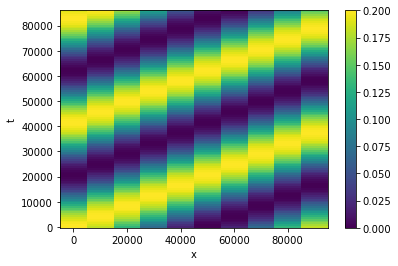

In [9]:
vf.sel(x=np.arange(x_i,L,x_step), t=np.arange(t_i,d2s,t_step)).plot()

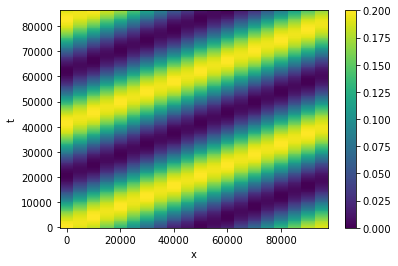

In [10]:
v_inter.plot()

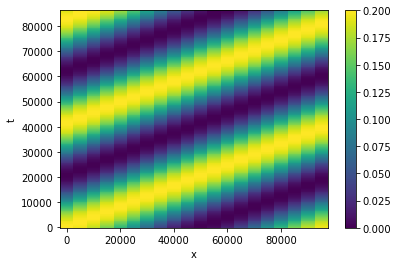

In [11]:
#Analytical velocity on the interpolated grid
len_tg=len(t_inter)
len_xg=len(x_inter)
VG=np.zeros((len_tg, len_xg))
for i in range(len_tg):
    for j in range (len_xg):
        VG[i,j]=analytical_velocity_advected(t_inter[i], x_inter[j], um, uw, w, k)
v_analytical= xr.DataArray(data=VG, dims=["t", "x"], coords=dict(t=(["t"], t_inter),x=(["x"], x_inter)))
v_analytical.plot()

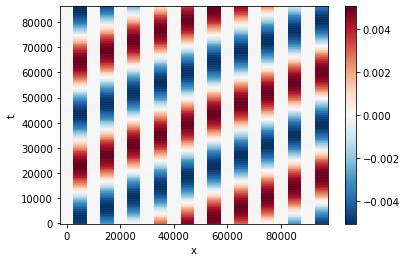

In [12]:
(v_inter-v_analytical).plot()

In [13]:
#Interpolated velocity with the x array method interp()
v_xr=vf.interp(t=t_inter, x=x_inter)

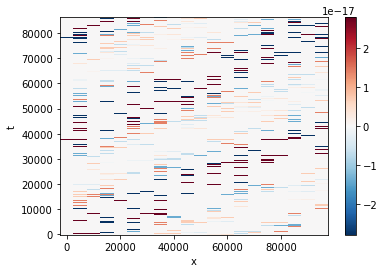

In [14]:
(v_inter-v_xr).plot()